In [1]:
#Installing all the necessary packages in order to undergo the prediction
import numpy as np
from math import sqrt
import pandas as pd
from pandas import Series , concat
from pandas import DataFrame , datetime
from pandas import read_csv
import pandas as pd
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
#Loading the data set
dataset = pd.read_csv('C:/Users/gurun/Desktop/ProjectCPS/EXP3/DPPdataset.csv',index_col="DATETIME")
dataset.head()

,air temp degree,Air density,wind speed at 100m (m/s),wind direction at 100m (deg),Power (KW)
DATETIME,,,,,
1/1/2007 0:00,2.430,1.223,11.673,244.189,15701
1/1/2007 0:05,2.387,1.224,11.395,244.755,15498
1/1/2007 0:10,2.336,1.224,11.468,245.644,15568
1/1/2007 0:15,2.278,1.224,11.636,246.863,15691
1/1/2007 0:20,2.192,1.225,11.727,247.287,15719


In [3]:
# Framing the the sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df_set = DataFrame(data)
    columns = [df_set.shift(i) for i in range(1, lag+1)]
    columns.append(df_set)
    df_set = concat(columns, axis=1)
    df_set.fillna(0, inplace=True)
    return df_set

In [4]:
# creating a differenced series
def difference(Data_Set, interval=1):
    diff = list()
    for i in range(interval, len(Data_Set)):
        value = Data_Set[i] - Data_Set[i - interval]
        diff.append(value)
    return Series(diff)
# inverting the differenced value
def inverse_difference(history, Y_pred, interval=1):
    return Y_pred + history[-interval]

In [5]:
# Dropping all the features which we will not be using
del dataset['air temp degree']
del dataset['Air density']
del dataset['wind speed at 100m (m/s)']
del dataset['wind direction at 100m (deg)']
for i in range(0,15):
  dataset = dataset[:-1]
dataset.tail()

,Power (KW)
DATETIME,
12/31/2007 22:20,16000
12/31/2007 22:25,16000
12/31/2007 22:30,16000
12/31/2007 22:35,16000
12/31/2007 22:40,16000


In [6]:
# Performing scaling on the train data to [-1, 1]
from sklearn.preprocessing import MinMaxScaler
def scale(Xtrain, Xtest):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(Xtrain)
    Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1])
    Xtrain_scaled = scaler.transform(Xtrain)
    
    
# Performing scaling on the test data to [-1, 1]
    Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1])
    Xtest_scaled = scaler.transform(Xtest)
    return scaler, Xtrain_scaled, Xtest_scaled

In [7]:
# Performing inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    np_rowval = [x for x in X] + [value]
    array = np.array(np_rowval)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [8]:
# Hardcoding all variables
Lag_duration =24
Predict_Value_Size= 288
Epoch_Size = 6
Batch_Size = 1
Neurons_Size = 10

In [9]:
# fitting the LSTM model into a Training Data set
from keras.layers import Dense, LSTM
from keras.models import Sequential
def fit_lstm(Xtrain, batch_size, nb_epoch, neurons):
    X, y = Xtrain[:, 0:-1], Xtrain[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(Batch_Size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [10]:
# Variables Required for performing forwad walk validation on the test data set
Prediction = list()
Expectation = list()
Pred_plot = list()
Expectation_plot = list()
Test_Prediction = list()

In [11]:
# making an one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    Y_pred = model.predict(X, batch_size=1)
    return Y_pred[0,0]

In [12]:
# transforming the data into a stationary data set
Raw_val = dataset.values
Different_val = difference(Raw_val, 1)
# transforming the data into a  supervised learning
supervised = timeseries_to_supervised(Different_val, Lag_duration)
supervised_values = supervised.values

In [13]:
# splitting the dataset into train-sets and test-sets
Xtrain, Xtest = supervised_values[0:-Predict_Value_Size], supervised_values[-Predict_Value_Size:]
# perform scaling on the data
scaler, Xtrain_scaled, Xtest_scaled = scale(Xtrain, Xtest)

C:\Users\gurun\AppData\Local\conda\conda\envs\tensorflow-sessions\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [14]:
# fitting the LSTM model 
lstm_model = fit_lstm(Xtrain_scaled, Batch_Size, Epoch_Size, Neurons_Size)

Epoch 1/1
104816/104816 [==============================] - 163s 2ms/step - loss: 0.0011
Epoch 1/1
104816/104816 [==============================] - 165s 2ms/step - loss: 0.0011
Epoch 1/1
104816/104816 [==============================] - 185s 2ms/step - loss: 0.0010
Epoch 1/1
104816/104816 [==============================] - 186s 2ms/step - loss: 0.0010
Epoch 1/1
104816/104816 [==============================] - 177s 2ms/step - loss: 0.0010
Epoch 1/1
104816/104816 [==============================] - 232s 2ms/step - loss: 0.0010


In [15]:
for i in range(len(Xtest_scaled)):
    # making one-step forecast
    X, y = Xtest_scaled[i, 0:-1], Xtest_scaled[i, -1]
    Y_pred = forecast_lstm(lstm_model, 1, X)
    # Replacing the values of test scaled data with the newly predicted value.
    Test_Prediction = [Y_pred] + Test_Prediction 
    if len(Test_Prediction) > Lag_duration+1:
        Test_Prediction = Test_Prediction[:-1]
    if i+1<len(Xtest_scaled):
        if i+1 > Lag_duration+1:
            Xtest_scaled[i+1] = Test_Prediction
        else:
            Xtest_scaled[i+1] = np.concatenate((Test_Prediction, Xtest_scaled[i+1, i+1:]),axis=0)

    #Performing the invert scaling and invert differencing and store the forecasted values into an array
    Y_pred = invert_scale(scaler, X, Y_pred)
    Y_pred = inverse_difference(Raw_val, Y_pred, len(Xtest_scaled)+1-i)
    Expected_Val = Raw_val[len(Xtrain) + i + 1]
    Pred_plot.append(Y_pred)
    Expectation_plot.append(Expected_Val)
    if Expected_Val != 0:
        Prediction.append(Y_pred)
        Expectation.append(Expected_Val)
    print('Every 5th Minute Entry=%d, Predicted_Value=%f, Expected_Value=%f' % (i+1, Y_pred, Expected_Val))

Expectation = np.array(Expectation)
Prediction = np.array(Prediction)

Every 5th Minute Entry=1, Predicted_Value=11175.440590, Expected_Value=11088.000000
Every 5th Minute Entry=2, Predicted_Value=11289.888110, Expected_Value=11136.000000
Every 5th Minute Entry=3, Predicted_Value=11424.099877, Expected_Value=11157.000000
Every 5th Minute Entry=4, Predicted_Value=11448.350459, Expected_Value=11170.000000
Every 5th Minute Entry=5, Predicted_Value=11406.878828, Expected_Value=11199.000000
Every 5th Minute Entry=6, Predicted_Value=11363.723895, Expected_Value=11325.000000
Every 5th Minute Entry=7, Predicted_Value=11440.783179, Expected_Value=11609.000000
Every 5th Minute Entry=8, Predicted_Value=11703.875631, Expected_Value=11980.000000
Every 5th Minute Entry=9, Predicted_Value=12066.389355, Expected_Value=12145.000000
Every 5th Minute Entry=10, Predicted_Value=12225.522582, Expected_Value=11985.000000
Every 5th Minute Entry=11, Predicted_Value=12063.390164, Expected_Value=11590.000000
Every 5th Minute Entry=12, Predicted_Value=11690.693043, Expected_Value=11

Every 5th Minute Entry=199, Predicted_Value=492.915220, Expected_Value=0.000000
Every 5th Minute Entry=200, Predicted_Value=488.034266, Expected_Value=0.000000
Every 5th Minute Entry=201, Predicted_Value=479.420063, Expected_Value=0.000000
Every 5th Minute Entry=202, Predicted_Value=463.843726, Expected_Value=2.000000
Every 5th Minute Entry=203, Predicted_Value=443.182351, Expected_Value=7.000000
Every 5th Minute Entry=204, Predicted_Value=420.729081, Expected_Value=15.000000
Every 5th Minute Entry=205, Predicted_Value=396.085061, Expected_Value=27.000000
Every 5th Minute Entry=206, Predicted_Value=369.609769, Expected_Value=46.000000
Every 5th Minute Entry=207, Predicted_Value=344.880288, Expected_Value=64.000000
Every 5th Minute Entry=208, Predicted_Value=314.859965, Expected_Value=82.000000
Every 5th Minute Entry=209, Predicted_Value=280.745744, Expected_Value=197.000000
Every 5th Minute Entry=210, Predicted_Value=338.678076, Expected_Value=331.000000
Every 5th Minute Entry=211, Pre

In [16]:
from sklearn.metrics import mean_squared_error
print("Root mean squared error: %.3f" % sqrt(mean_squared_error(Expected_Val, Y_pred)))

Root mean squared error: 31.495


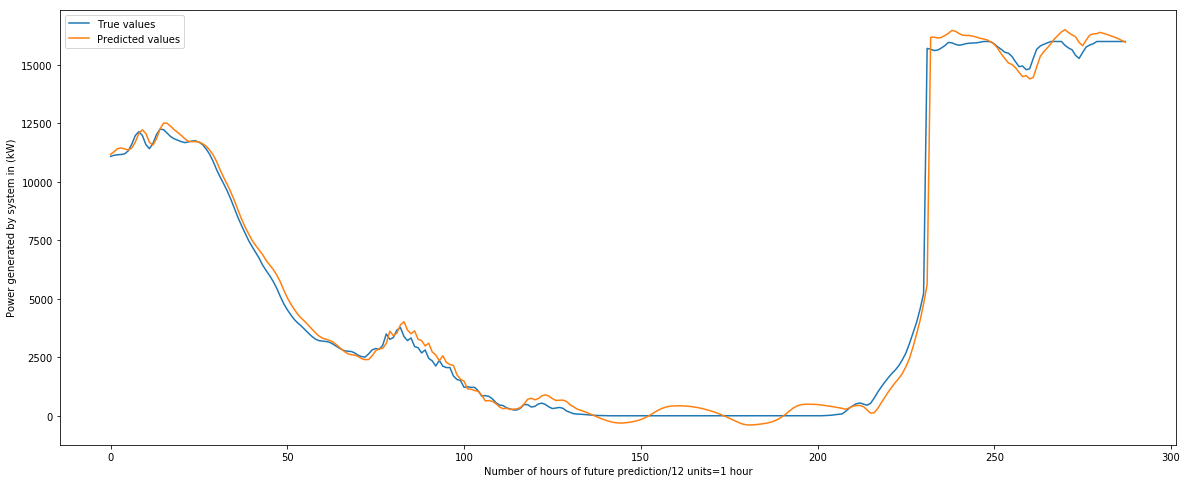

In [19]:
# Plot between the predicted power by the system and the number of hours
from matplotlib import pyplot
pyplot.figure(figsize=(20,8))
pyplot.plot(Expectation_plot, label="True values")
pyplot.plot(Pred_plot, label="Predicted values")
pyplot.xlabel("Number of hours of future prediction/12 units=1 hour")
pyplot.ylabel("Power generated by system in (kW)")
pyplot.legend()
pyplot.show()

In [18]:
# Calculating Mean Absolute Percent Error - Performance Evaluation
from sklearn.metrics import mean_squared_error
mape = (np.mean(np.abs((Expectation - Prediction) / Expectation))*100)
print("Calculation of the Mean Absolute Percent Error: ", mape )

Calculation of the Mean Absolute Percent Error:  197.62097972814988
